Notebook basado en el artículo:
What is the expectation maximization algorithm?, by Chuong B Do & Serafim Batzoglou
http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf

Problema:
    
    Se tienen dos monedas con sesgos desconocidos.  Es decir, la probabilidad de que salga cara NO es 1/2, y además es diferente para cada una.  Se busca determinar los valores de esas probabilidades. 
    
    Para eso se realiza el siguiente experimento:
    
    1. Elegir una moneda al azar
    2. sortear esa moneda 10 veces
    3. repetir (1.) 5 veces
    
Al final se tienen en total 50 sorteos de las monedas.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

Definir una funcion que muestre la distribucion binomial (muchos resultados de simular una moneda)

In [2]:
def plot_binomial(p=0.5, n=10):
    a=range(n+1)
    fig, ax = plt.subplots(figsize=(6,4))
    y = [0]*(n+1)
    for i in a:
        y[i] =  stats.binom.pmf(i, n, p)
    ax.bar(a,y,label="$p = %.1f$" % p)
    ax.set_ylabel('FMP del nro. de caras')
    ax.set_xlabel('$k$')
    ax.set_ylim((0,0.5))
    ax.set_xlim((-1,n+1))
    ax.legend()
    return fig

Mostrar la distribucion Binomial

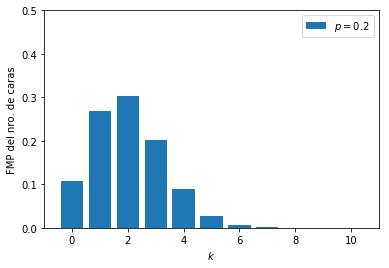

In [3]:
f = plot_binomial(0.2)

## Simular un experimento:

In [57]:
Nexp = 50   # numero de experimentos (monedas)
Nsor = 300  # numero de veces que tiro la moneda en cada experimento
pA = 0.3   # probabilidad de que salga cara en la moneda A
pB = 0.7   # probabilidad de que salga cara en la moneda B
pM = 0.5   # probabiidad de elegir la moneda A
N_itera = 10 # cantidad de iteraciones en el metodo EM
obs = np.empty([Nexp, Nsor], dtype=bool)

In [58]:
def gen_bernoulli(p):
    x = random.random()
    if x<p:
        r = True
    else:
        r = False
    return(r)

In [59]:
def monedas(emA,Nexp):
    As = np.array(["A"]*Nexp)
    Bs = np.array(["B"]*Nexp)
    T = As
    T[emA] = As[emA]
    T[~emA] = Bs[~emA]
    return(T)

In [60]:
def eP(emA, pA, pB, Nexp):
    As = np.array(["A"]*Nexp)
    Bs = np.array(["B"]*Nexp)
    T = As
    T[emA] = As[emA]
    T[~emA] = Bs[~emA]
    return(T)

Elegir monedas:

In [61]:
mA = np.array([gen_bernoulli(pM) for _ in range(Nexp)])
print mA
T = monedas(mA, Nexp)
print(T)

[ True False False  True  True False  True  True  True False  True False
  True  True  True False False  True  True False  True  True False False
  True  True False False False  True False  True False  True  True  True
  True False  True  True False  True  True False False False  True  True
  True  True]
['A' 'B' 'B' 'A' 'A' 'B' 'A' 'A' 'A' 'B' 'A' 'B' 'A' 'A' 'A' 'B' 'B' 'A'
 'A' 'B' 'A' 'A' 'B' 'B' 'A' 'A' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'A' 'A' 'A'
 'A' 'B' 'A' 'A' 'B' 'A' 'A' 'B' 'B' 'B' 'A' 'A' 'A' 'A']


Tiradas de las monedas:

In [62]:
for i in range(Nexp):
    
    if(mA[i]):
        p = pA
    else:
        p = pB
        
    obs[i] = [gen_bernoulli(p) for _ in range(Nsor)]

In [63]:
print obs

[[False False False ..., False False  True]
 [ True  True False ..., False False  True]
 [ True  True  True ...,  True  True False]
 ..., 
 [ True False  True ..., False False False]
 [False False False ..., False False False]
 [False False False ...,  True False False]]


------------------------------------>> Objetivo: estimar pA y pB <<----------------------------------------

## Estimaciones de la probabilidad: Caso "completo"

![title](EM1.png)

In [64]:
fA = 1.0 * np.sum(obs[mA]) / np.size(obs[mA])
fB = 1.0 * np.sum(obs[~mA]) / np.size(obs[~mA])
print(pA, fA, pB, fB)

(0.3, 0.3051111111111111, 0.7, 0.6941666666666667)


/home/marce/TeachJob/Astrometria/pyramid/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


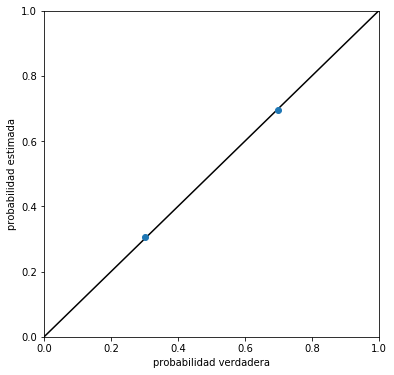

In [65]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([0,1],[0,1],"k-")
plt.plot([pA,pB],[fA,fB],"o")
ax.set_xlabel('probabilidad verdadera')
ax.set_ylabel('probabilidad estimada')
ax.set_ylim((0,1))
ax.set_xlim((0,1))
ax.legend()

### Estimaciones de la probabilidad: Caso "incompleto": 
#### Aplicación del algoritmo de expectación-maximización

#### paso 1: asumir valores para los parámetos pA y pB (desconocidos)

In [66]:
epA = 0.6
epB = 0.5

#### paso 2: determinar para cada experimento cual de las monedas es la más probable

In [67]:
# Experimento 1:
print(obs[0])
Ncaras = np.sum(obs[0])
L_A1 = stats.binom.pmf(Ncaras,Nsor,epA)
L_B1 = stats.binom.pmf(Ncaras,Nsor,epB)
print(L_A1, L_B1)

[False False False False  True  True False False  True False  True False
 False False  True False False  True  True False  True  True  True  True
 False  True  True  True False False False False False False  True  True
 False  True False False False False False False False False  True False
 False False False False False False False False False False False False
  True  True False  True False  True False False False False False False
 False False False False False False False False False  True False  True
 False False False False False  True False  True False  True False False
 False False  True  True False False False False  True  True False False
 False False  True False False  True  True False False  True False False
 False  True False False  True False False  True False  True  True  True
 False False False False False False False  True False False False False
 False False False  True False False  True False False  True False False
 False  True False False  True False  True False Fa

In [68]:
# para los 5 experimentos:
emA = []
for X in obs:
    Ncaras = np.sum(X)
    L_A = stats.binom.pmf(Ncaras,Nsor,epA)
    L_B = stats.binom.pmf(Ncaras,Nsor,epB)
    if(L_A>L_B): 
        S="A"
        emA.append(True)
    else:
        S="B"
        emA.append(False)
    print('La moneda más probable es la {}.  Valores: {} y {}'.format(S, L_A, L_B))
emA = np.array(emA)

La moneda más probable es la B.  Valores: 2.25364692559e-24 y 1.1204763318e-11
La moneda más probable es la A.  Valores: 0.00113305643391 y 2.40286767666e-10
La moneda más probable es la A.  Valores: 0.00489709993742 y 7.88630512907e-09
La moneda más probable es la B.  Valores: 1.24835712294e-27 y 7.06973618955e-14
La moneda más probable es la B.  Valores: 4.53238750886e-27 y 1.71119750952e-13
La moneda más probable es la A.  Valores: 0.0204542123755 y 5.62802714805e-07
La moneda más probable es la B.  Valores: 5.69502129344e-26 y 9.55621560495e-13
La moneda más probable es la B.  Valores: 1.24835712294e-27 y 7.06973618955e-14
La moneda más probable es la B.  Valores: 7.44422734463e-24 y 2.46743192216e-11
La moneda más probable es la A.  Valores: 7.69921484877e-05 y 9.55621560495e-13
La moneda más probable es la B.  Valores: 1.61943733463e-26 y 4.07611092154e-13
La moneda más probable es la A.  Valores: 4.92603793641e-05 y 4.07611092154e-13
La moneda más probable es la B.  Valores: 7.4

In [69]:
print(emA)
print(monedas(emA, Nexp))

[False  True  True False False  True False False False  True False  True
 False False False  True  True False False  True False False  True  True
 False False  True  True  True False  True False  True False False False
 False  True False False  True False False  True  True  True False False
 False False]
['B' 'A' 'A' 'B' 'B' 'A' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'B' 'B' 'A' 'A' 'B'
 'B' 'A' 'B' 'B' 'A' 'A' 'B' 'B' 'A' 'A' 'A' 'B' 'A' 'B' 'A' 'B' 'B' 'B'
 'B' 'A' 'B' 'B' 'A' 'B' 'B' 'A' 'A' 'A' 'B' 'B' 'B' 'B']


#### paso 3: 

#### IDEA: _asumo_ estos valores para las variables latentes y estimo los parámetros usando _maximum likelihood_

In [70]:
# Lo mismo que para el caso completo, pero usando emA en lugar de mA:
fA = 1.0 * np.sum(obs[emA]) / np.size(obs[emA])
fB = 1.0 * np.sum(obs[~emA]) / np.size(obs[~emA])
print(pA, fA, pB, fB)

(0.3, 0.6941666666666667, 0.7, 0.3051111111111111)


#### Repito lo mismo hasta convergencia:

In [71]:
# estima inicial
epA = 0.9
epB = 0.1
print(emA, epA, epB)

for _ in range(10):
    emA = []
    for X in obs:
        Ncaras = np.sum(X)
        L_A = stats.binom.pmf(Ncaras,Nsor,epA)
        L_B = stats.binom.pmf(Ncaras,Nsor,epB)
        if(L_A>L_B): 
            emA.append(True)
        else:
            emA.append(False)
    emA = np.array(emA)
    
    epA = 1.0 * np.sum(obs[emA]) / np.size(obs[emA])
    epB = 1.0 * np.sum(obs[~emA]) / np.size(obs[~emA])
    print(emA, epA, epB)

(array([False,  True,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False,  True,  True, False,
       False,  True, False, False,  True,  True, False, False,  True,
        True,  True, False,  True, False,  True, False, False, False,
       False,  True, False, False,  True, False, False,  True,  True,
        True, False, False, False, False], dtype=bool), 0.9, 0.1)
(array([False,  True,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False,  True,  True, False,
       False,  True, False, False,  True,  True, False, False,  True,
        True,  True, False,  True, False,  True, False, False, False,
       False,  True, False, False,  True, False, False,  True,  True,
        True, False, False, False, False], dtype=bool), 0.6941666666666667, 0.3051111111111111)
(array([False,  True,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False,  True,  True, Fa

#### EM: en lugar de elegir la moneda "más probable", tomo una probabilidad para cada moneda

En la version anterior, asignamos "probabilidades" 0 y 1 a las monedas según cual era la más probable, es decir, asumimos la variable latente como conocida.   Ahora vamos a asignarle una probabilidad a cada moneda.

Para el experimento 1:

In [72]:
for i in range(Nexp):    
    if(mA[i]):
        p = pA
    else:
        p = pB        
    obs[i] = [gen_bernoulli(p) for _ in range(Nsor)]

In [73]:
Ncaras = np.sum(obs[0])

L_A = stats.binom.pmf(Ncaras,Nsor,epA)
L_B = stats.binom.pmf(Ncaras,Nsor,epB)

# EXPECTACION

mpA = L_A / (L_A + L_B)
mpB = L_B / (L_A + L_B)

print (L_A, L_B, mpA, mpB)

(3.2650570167527731e-46, 0.045778631565706641, 7.1322730826202087e-45, 1.0)


El **modelo** ahora es la distribunción Binomial con los parámetros estimados **mpA** y **mpB**

Ahora hacemos el paso de MAXIMIZACION

In [74]:
eCA = Ncaras*mpA
eXA = Ncaras*mpA
eCB = Ncaras*mpB
eXB = Ncaras*mpB

print(eCA, eXA, eCB, eXB)

(6.2764003127057836e-43, 6.2764003127057836e-43, 88.0, 88.0)


Para los 5 experimentos:

In [75]:
eCAT = []
eXAT = []
eCBT = []
eXBT = []

for X in obs:    
    Ncaras = np.sum(X)
    L_A = stats.binom.pmf(Ncaras,Nsor,epA)
    L_B = stats.binom.pmf(Ncaras,Nsor,epB)
    mpA = L_A / (L_A + L_B)
    mpB = L_B / (L_A + L_B)
    
    eCA = Ncaras*mpA
    eCAT.append(eCA)
    
    eXA = (Nsor-Ncaras)*mpA
    eXAT.append(eXA)    
    
    eCB = Ncaras*mpB
    eCBT.append(eCB)
        
    eXB = (Nsor-Ncaras)*mpB
    eXBT.append(eXB)
        
print(np.sum(eCAT), np.sum(eXAT), np.sum(eCBT), np.sum(eXBT))

(4163.0, 1837.0, 2691.0, 6309.0)


![title](EM2.png)

In [76]:
a = stats.binom.pmf(5,10,0.6)
b= stats.binom.pmf(5,10,0.5)

In [77]:
a / (a+b)

0.4491489261009366

In [78]:
b / (a + b)

0.5508510738990634

In [79]:
epA = np.sum(eCAT) / (np.sum(eCAT) + np.sum(eXAT))
epB = np.sum(eCBT) / (np.sum(eCBT) + np.sum(eXBT))

print(epA, epB)

(0.6938333333333333, 0.29899999999999999)


## PASO 3: EM

In [80]:
epA = 0.4
epB = 0.6

ipA = []
ipB = []

for itera in range(N_itera):

    eCAT = []
    eXAT = []
    eCBT = []
    eXBT = []

    for X in obs:
               
        Ncaras = np.sum(X)
        L_A = stats.binom.pmf(Ncaras,Nsor,epA)
        L_B = stats.binom.pmf(Ncaras,Nsor,epB)
        mpA = L_A / (L_A + L_B)
        mpB = L_B / (L_A + L_B)
        
        eCA = Ncaras*mpA
        eCAT.append(eCA)
        
        eXA = (Nsor-Ncaras)*mpA
        eXAT.append(eXA)    
        
        eCB = Ncaras*mpB
        eCBT.append(eCB)
            
        eXB = (Nsor-Ncaras)*mpB
        eXBT.append(eXB)
        
    epA = np.sum(eCAT) / (np.sum(eCAT) + np.sum(eXAT))
    epB = np.sum(eCBT) / (np.sum(eCBT) + np.sum(eXBT))
    
    ipA.append(epA)
    ipB.append(epB)
    
    print(itera+1, epA, epB)
    

(1, 0.29899999999999999, 0.6938333333333333)
(2, 0.29899999999999999, 0.6938333333333333)
(3, 0.29899999999999999, 0.6938333333333333)
(4, 0.29899999999999999, 0.6938333333333333)
(5, 0.29899999999999999, 0.6938333333333333)
(6, 0.29899999999999999, 0.6938333333333333)
(7, 0.29899999999999999, 0.6938333333333333)
(8, 0.29899999999999999, 0.6938333333333333)
(9, 0.29899999999999999, 0.6938333333333333)
(10, 0.29899999999999999, 0.6938333333333333)


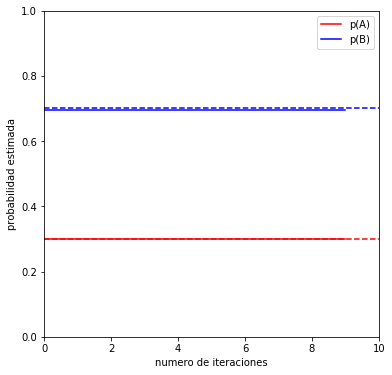

In [81]:
x = range(N_itera)

fig, ax = plt.subplots(figsize=(6,6))
l1 = plt.plot(x, ipA,"r-", label="A")
l2 = plt.plot(x, ipB,"b-", label="B")
ax.axhline(y=pA, color='r', linestyle='--')
ax.set_xlabel('numero de iteraciones')
ax.axhline(y=pB, color='b', linestyle='--')
ax.set_ylabel('probabilidad estimada')
ax.set_ylim((0,1))
ax.set_xlim((0,N_itera))
ax.legend(labels=["p(A)", "p(B)"])